### HDR: Graph Clustering with Affinity Propagation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn

from pprint import pprint
from sklearn.cluster import AffinityPropagation

%matplotlib inline

#### Settings

In [2]:
years = np.arange(2010, 2016+1)

density   = 'full'  # ['full', 'sparse']
mean_type = 'mean'  # ['mean', 'median', 'wmean']

#### Set input/output folder

In [3]:
data_in  = f'../data/HDR_4a_graph_formation/{mean_type}'
# pprint(sorted(list(os.listdir(data_in))))

data_ai_in  =  '../data/CRU_2c_aggregate_attr_by_period/annually'
data_hd_in  =  '../data/HDR_1c_aggregate_attr_by_year'
data_mt     =  '../data/HDR_mutual_attributes_and_countries'

data_out = f'../data/HDR_4c_graph_clustering/{mean_type}/{density}'
if not os.path.exists(data_out):
    os.makedirs(data_out)

plot_out = f'../plots/HDR_4c_graph_clustering/{idx_type}/{mean_type}/{density}'
if not os.path.exists(plot_out):
    os.makedirs(plot_out)

#### Load input data

In [4]:
graphs = dict()

ai = dict()
hd = dict()

for year in years:
    graphs[year] = pd.read_csv(f'{data_in}/l1_{year}.csv', index_col='Country')  # similarity matrix!
    
    # read Aridity Index (AI) and Human Development Index (HDI) data
    ai[year] = pd.read_csv(f'{data_ai_in}/{year}.csv', index_col='Country')['Aridity Index (AI)']
    hd[year] = pd.read_csv(f'{data_hd_in}/{year}.csv', index_col='Country')['Human Development Index (HDI)']

#### Modularity

In [5]:
# %load '../snippets/modularity.py'
def modularity(df, groups):
    labels = set(groups)

    edge_set = set()
    value = 0

    for i in labels:
        for j in labels:
            cs1 = groups[groups == i].index
            cs2 = groups[groups == j].index

            for c1 in cs1:
                for c2 in cs2:
                    edge = f'{c1}_{c2}' if c1 < c2 else f'{c2}_{c1}'

                    if edge not in edge_set:
                        if i == j:
                            value += df.loc[c1, c2]
                        else:
                            value -= df.loc[c1, c2]

                        edge_set.add(edge)

    return value

##### <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation">Affinity Propagation</a>

In [8]:
clusterings = dict()
dampings = np.round(np.arange(0.5, 0.90001, 0.1), 2)

aff_prop_df = pd.DataFrame(columns=dampings, index=years)

for damp in dampings:
    clusterings[damp] = dict()
    
    plot_out_damp = f'{plot_out}/{damp}'
    if not os.path.exists(plot_out_damp):
        os.makedirs(plot_out_damp)
    
    f, axs = plt.subplots(len(years), 3, figsize=(16, 25))  # sharex='col', sharey='col'

    for i in range(len(years)):
        year = years[i]

        cls = AffinityPropagation(damping=damp)  # damping=damp, affinity='precomputed'
        cls.fit(1 - graphs[year])  # input: similarity = 1 - distance
        labels = cls.labels_.flatten()
        clusters = pd.Series(labels, index=graphs[year].index).sort_values()
        clusterings[damp][year] = clusters

        clusters_df = pd.concat([clusters, ai[year], hd[year]], axis=1, sort=True).dropna()
        clusters_df.columns = ['Cluster', 'AI', 'HDI']
        clusters_df = clusters_df.sort_values(by=['Cluster', 'HDI'])
        
        aff_prop_df.loc[year, damp] = modularity(graphs[year], clusterings[damp][year])
        
        # Heatmaps
        seaborn.heatmap((1 - graphs[year]).reindex(index=clusters.index,
                                               columns=clusters.index),
                        ax=axs[i][0], cbar=False, cmap='Oranges', vmax=1, vmin=0)
        axs[i][0].set_title(f'{year} (K = {len(set(labels))})')

        axs[i][0].set_xticks([])
        axs[i][0].set_yticks([])
        axs[i][0].set_xlabel('')
        axs[i][0].set_ylabel('')

        offset = 0
        for j in range(len(set(labels))):
            block_size = len(clusters[clusters == j])
            idx =  block_size + offset

            axs[i][0].hlines(idx, xmin=offset, xmax=idx)
            axs[i][0].vlines(idx, ymin=offset, ymax=idx)

            axs[i][0].hlines(offset, xmin=offset, xmax=idx)
            axs[i][0].vlines(offset, ymin=offset, ymax=idx)

            offset = idx

        plt.figure(figsize=(8, 6))
        seaborn.heatmap((1 - graphs[year]).reindex(index=clusters.index,
                                               columns=clusters.index),
                        cbar=False, cmap='Oranges', vmax=1, vmin=0)

        offset = 0
        for j in range(len(set(labels))):
            block_size = len(clusters[clusters == j])
            idx =  block_size + offset

            plt.hlines(idx, xmin=offset, xmax=idx)
            plt.vlines(idx, ymin=offset, ymax=idx)

            plt.hlines(offset, xmin=offset, xmax=idx)
            plt.vlines(offset, ymin=offset, ymax=idx)

            offset = idx

        plt.savefig(f'{plot_out_damp}/heatmap_{year}')
        plt.close()

        # Human Development Index groups
        axs[i][1].plot(clusters_df['Cluster'], clusters_df['HDI'], 'o', alpha=0.4)
        axs[i][1].set_title(f'HDI {year}')
        axs[i][1].set_xticks([])

        plt.figure(figsize=(16, 9))
        plt.plot(clusters_df['Cluster'], clusters_df['HDI'], 'o', alpha=0.4)
        plt.title(f'HDI {year}')
        plt.savefig(f'{plot_out_damp}/hdi_{year}')
        plt.close()

        # Aridity Index groups
        axs[i][2].plot(clusters_df['Cluster'], clusters_df['AI'], 'o', alpha=0.4)
        axs[i][2].set_title(f'AI {year}')
        axs[i][2].set_xticks([])

        plt.figure(figsize=(16, 9))
        plt.plot(clusters_df['Cluster'], clusters_df['AI'], 'o', alpha=0.4)
        plt.title(f'AI {year}')
        plt.savefig(f'{plot_out_damp}/ai_{year}')
        plt.close()
    
    f.savefig(f'{plot_out_damp}/aff_prop_results')
    plt.close(f)
#     plt.show()

aff_prop_df = aff_prop_df.astype('float')
aff_prop_df.to_csv(f'{data_out}/aff_prop.csv', index_label='Year')

In [9]:
display(aff_prop_df.style.background_gradient(cmap='Oranges', axis=1))

,0.5,0.6,0.7,0.8,0.9
2010,-3059.26,-3050.68,-2953.9,-3049.25,-3034.91
2011,-2986.45,-2986.45,-2982.44,-3054.75,-2985.73
2012,-2967.14,-2943.08,-2965.37,-2940.22,-2940.22
2013,-2958.67,-3025.65,-2946.96,-2946.96,-2946.96
2014,-3031.69,-2991.36,-2991.36,-2988.06,-2988.06
2015,-2864.01,-2857.72,-2862.4,-2857.72,-2857.72
2016,-2933.44,-3023.12,-2957.99,-2957.99,-2957.99


##### Best Affinity Propagation

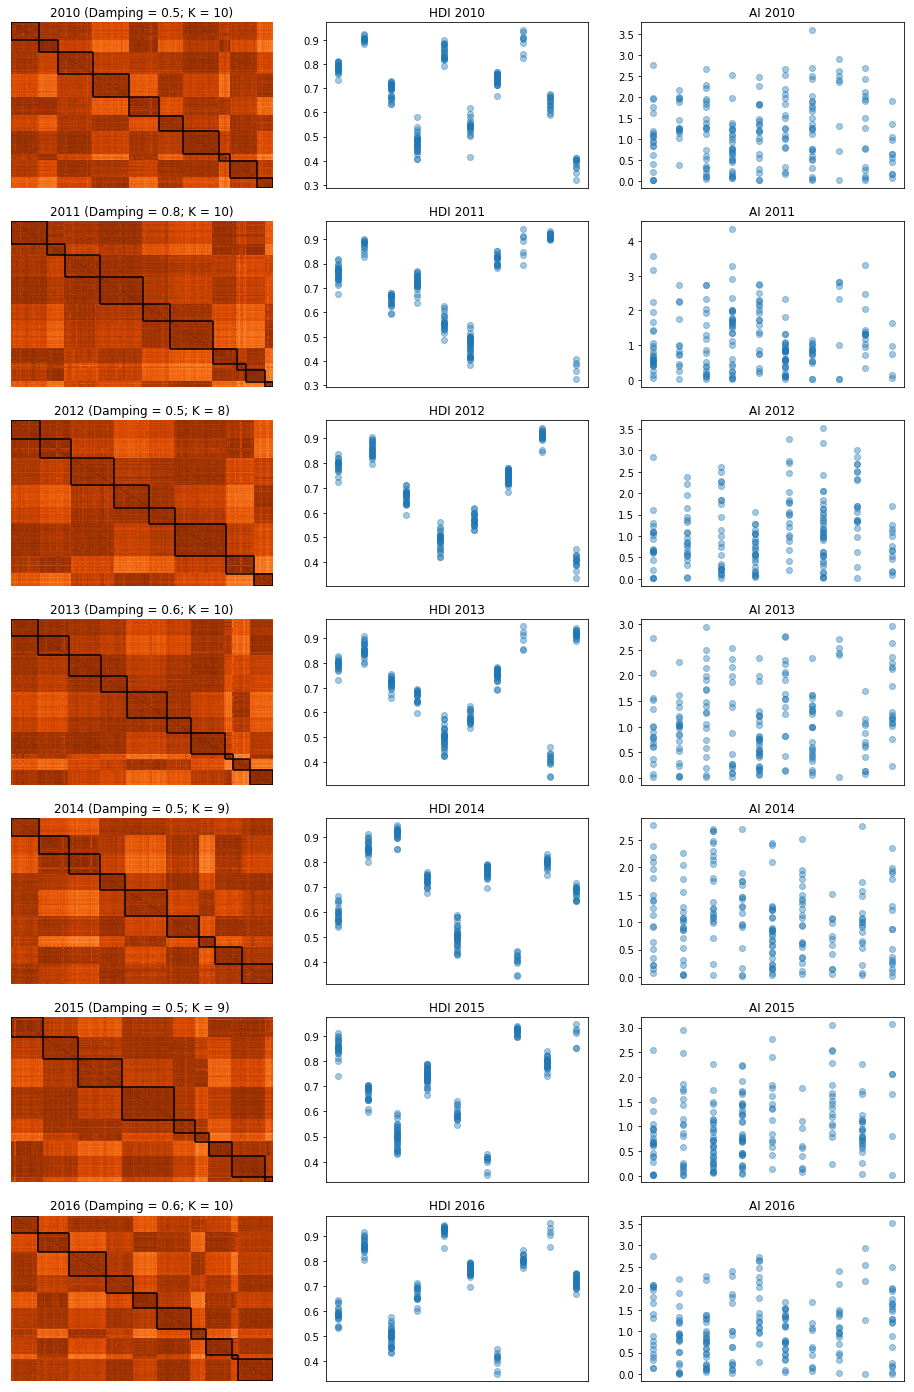

In [10]:
best_groupings = pd.DataFrame(index=graphs[years[0]].index, columns=years)

plot_out_ovr = f'{plot_out}/overall'
if not os.path.exists(plot_out_ovr):
    os.makedirs(plot_out_ovr)

f, axs = plt.subplots(len(years), 3, figsize=(16, 25))  # sharex='col', sharey='col'

for i in range(len(years)):
    year = years[i]
    damp = aff_prop_df.idxmin(axis=1)[year]

    cls = AffinityPropagation(damping=damp)  # damping=damp, affinity='precomputed'
    cls.fit(1 - graphs[year])  # input: similarity = 1 - distance
    labels = cls.labels_.flatten()
    clusters = pd.Series(labels, index=graphs[year].index).sort_values()
    clusterings[damp][year] = clusters
    clusters = clusterings[damp][year]
    
    best_groupings[year] = clusters

    clusters_df = pd.concat([clusters, ai[year], hd[year]], axis=1, sort=True).dropna()
    clusters_df.columns = ['Cluster', 'AI', 'HDI']
    clusters_df = clusters_df.sort_values(by=['Cluster', 'HDI'])

    # Heatmaps
    seaborn.heatmap((1 - graphs[year]).reindex(index=clusters.index,
                                           columns=clusters.index),
                    ax=axs[i][0], cbar=False, cmap='Oranges', vmax=1, vmin=0)
    axs[i][0].set_title(f'{year} (Damping = {damp}; K = {len(set(labels))})')

    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('')

    offset = 0
    for j in range(len(set(labels))):
        block_size = len(clusters[clusters == j])
        idx =  block_size + offset

        axs[i][0].hlines(idx, xmin=offset, xmax=idx)
        axs[i][0].vlines(idx, ymin=offset, ymax=idx)

        axs[i][0].hlines(offset, xmin=offset, xmax=idx)
        axs[i][0].vlines(offset, ymin=offset, ymax=idx)

        offset = idx

    plt.figure(figsize=(8, 6))
    seaborn.heatmap((1 - graphs[year]).reindex(index=clusters.index,
                                           columns=clusters.index),
                    cbar=False, cmap='Oranges', vmax=1, vmin=0)

    offset = 0
    for j in range(len(set(labels))):
        block_size = len(clusters[clusters == j])
        idx =  block_size + offset

        plt.hlines(idx, xmin=offset, xmax=idx)
        plt.vlines(idx, ymin=offset, ymax=idx)

        plt.hlines(offset, xmin=offset, xmax=idx)
        plt.vlines(offset, ymin=offset, ymax=idx)

        offset = idx

    plt.savefig(f'{plot_out_ovr}/heatmap_{year}')
    plt.close()

    # Human Development Index groups
    axs[i][1].plot(clusters_df['Cluster'], clusters_df['HDI'], 'o', alpha=0.4)
    axs[i][1].set_title(f'HDI {year}')
    axs[i][1].set_xticks([])

    plt.figure(figsize=(16, 9))
    plt.plot(clusters_df['Cluster'], clusters_df['HDI'], 'o', alpha=0.4)
    plt.title(f'HDI {year}')
    plt.savefig(f'{plot_out_ovr}/hdi_{year}')
    plt.close()

    # Aridity Index groups
    axs[i][2].plot(clusters_df['Cluster'], clusters_df['AI'], 'o', alpha=0.4)
    axs[i][2].set_title(f'AI {year}')
    axs[i][2].set_xticks([])

    plt.figure(figsize=(16, 9))
    plt.plot(clusters_df['Cluster'], clusters_df['AI'], 'o', alpha=0.4)
    plt.title(f'AI {year}')
    plt.savefig(f'{plot_out_ovr}/ai_{year}')
    plt.close()

best_groupings.to_csv(f'{data_out}/best_groupings.csv')

f.savefig(f'{plot_out_ovr}/aff_prop_results')
# plt.close(f)
plt.show()